# Dyna Agent

In [1]:
import os
while os.path.basename(os.getcwd()) != "MountainCar-RL":
    os.chdir('..')

import gymnasium as gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from agents.Dyna_agent import DynaAgent
from agents.data_processing import *

In [2]:
seed = 103

# Create env
max_episode_steps=200
env = gym.make('MountainCar-v0', max_episode_steps=max_episode_steps)

# Create agent
action_space = np.array([0, 1, 2])
state_space = np.array([[-1.2, -0.07], [0.6, 0.07]])

# Setup hyperparameters
eps_max = 0.9
eps_min = 0.05
t_at_capacity = 100000  # number of iterations before reaching eps_min (e^-5 =~ 0)
eps = lambda t : eps_min + (eps_max - eps_min) * math.exp(-t * 5. / t_at_capacity)

discr_step = np.array([0.025, 0.005])
k = 20

gamma = 0.99
buffer_size = 10000
batch_size = 64
start_sampling = 1000

agent = DynaAgent(action_space, state_space=state_space, discr_step=discr_step, k=k,
                   gamma=gamma, eps=eps, buffer_size=buffer_size, start_sampling=start_sampling, random_seed=seed)

In [3]:
n_episodes = 3000

partial_times = np.array([100, 200, 350, 500, 1000, 2000], dtype=int)
partial_times_set = set(partial_times)
partial_max_Q_values = np.empty((partial_times.size, agent.num_states_vect[1], agent.num_states_vect[0]), dtype=float)
partial_visited_states = np.empty((partial_times.size, agent.num_states_vect[1], agent.num_states_vect[0]), dtype=bool)
partial_counter = 0

episode_seeds = np.zeros(n_episodes, dtype=int)
initial_xs = np.zeros(n_episodes, dtype=float)
durations = np.zeros(n_episodes, dtype=int)
q_updates = np.zeros(n_episodes, dtype=float)
rewards = np.zeros(n_episodes, dtype=float)

q_updates_steps = []

rng_seed = np.random.default_rng(seed+1)
for episode in range(n_episodes):
    episode_seed = rng_seed.integers(2147483647).item()
    episode_seeds[episode] = episode_seed
    
    state, _ = env.reset(seed=episode_seed)
    done = False

    initial_xs[episode] = state[0].item()
    
    episode_reward = 0
    episode_q_update = 0
    episode_steps = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        agent.observe(state, action, next_state, reward)
        q_update = agent.update(state, action, next_state, reward)

        state = next_state
        done = terminated or truncated

        episode_reward += reward
        episode_steps += 1
        episode_q_update += q_update

        q_updates_steps.append(q_update)
        
    print(f"Episode: {episode}, Reward: {episode_reward: .4f}, q_update: {episode_q_update/episode_steps: .2e}, Steps: {episode_steps}, epsilon: {agent.eps(agent.updates_counter): .4f}")

    durations[episode] = episode_steps
    q_updates[episode] = episode_q_update
    rewards[episode] = episode_reward

    if (episode+1) in partial_times_set:
        partial_max_Q_values[partial_counter] = np.max(agent.Q, axis=1).reshape((agent.num_states_vect[0], agent.num_states_vect[1])).T
        partial_visited_states[partial_counter] = (np.sum(agent.state_action_counter, axis=1) > 0).astype(bool).reshape((agent.num_states_vect[0], agent.num_states_vect[1])).T
        partial_counter += 1

q_updates_steps = np.array(q_updates_steps)

max_Q_values = np.max(agent.Q, axis=1).reshape((agent.num_states_vect[0], agent.num_states_vect[1])).T
visited_states = (np.sum(agent.state_action_counter, axis=1) > 0).astype(bool).reshape((agent.num_states_vect[0], agent.num_states_vect[1])).T

Episode: 0, Reward: -200.0000, q_update: -6.67e-01, Steps: 200, epsilon:  0.8915
Episode: 1, Reward: -200.0000, q_update: -5.98e-01, Steps: 200, epsilon:  0.8832
Episode: 2, Reward: -200.0000, q_update: -6.32e-01, Steps: 200, epsilon:  0.8749
Episode: 3, Reward: -200.0000, q_update: -5.98e-01, Steps: 200, epsilon:  0.8667
Episode: 4, Reward: -200.0000, q_update: -5.27e-01, Steps: 200, epsilon:  0.8585
Episode: 5, Reward: -200.0000, q_update: -3.96e-01, Steps: 200, epsilon:  0.8505
Episode: 6, Reward: -200.0000, q_update: -3.02e-01, Steps: 200, epsilon:  0.8425
Episode: 7, Reward: -200.0000, q_update: -1.27e-01, Steps: 200, epsilon:  0.8346
Episode: 8, Reward: -200.0000, q_update: -1.29e-01, Steps: 200, epsilon:  0.8268
Episode: 9, Reward: -200.0000, q_update: -1.21e-01, Steps: 200, epsilon:  0.8191
Episode: 10, Reward: -200.0000, q_update: -6.93e-01, Steps: 200, epsilon:  0.8115
Episode: 11, Reward: -200.0000, q_update: -5.44e-01, Steps: 200, epsilon:  0.8039
Episode: 12, Reward: -200.

**OPTIONAL: save results**

In [23]:
data = {
    'seed': episode_seeds,
    'initial_x': initial_xs,
    'reward': rewards,
    'duration': durations,
    'q_update': q_updates
}

df = pd.DataFrame(data)

"""
df.to_csv('results/E_train_Dyna.csv', index=False)

np.save("results/E_q_updates_steps_Dyna", q_updates_steps)

np.save("results/E_max_Q_values_Dyna", max_Q_values)
np.save("results/E_visited_states_Dyna", visited_states)

np.save("results/E_partial_times_Dyna", partial_times)
np.save("results/E_partial_max_Q_values_Dyna", partial_max_Q_values)
np.save("results/E_partial_visited_states_Dyna", partial_visited_states)
"""

## Plotting

**OPTIONAL: load results**

In [2]:
df = pd.read_csv('results/E_train_Dyna.csv')

n_episodes = len(df.index)

seeds = df['seed'].to_numpy()
initial_xs = df['initial_x'].to_numpy()
rewards = df['reward'].to_numpy()
durations = df['duration'].to_numpy()
q_updates = df['q_update'].to_numpy()

q_updates_steps = np.load("results/E_q_updates_steps_Dyna.npy")

max_Q_values = np.load("results/E_max_Q_values_Dyna.npy")
visited_states = np.load("results/E_visited_states_Dyna.npy")

partial_times = np.load("results/E_partial_times_Dyna.npy")
partial_max_Q_values = np.load("results/E_partial_max_Q_values_Dyna.npy")
partial_visited_states = np.load("results/E_partial_visited_states_Dyna.npy")

**PLOT: episodes duration**

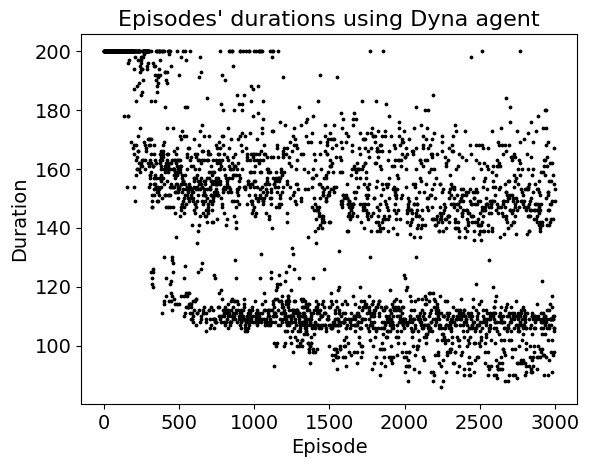

In [3]:
plt.scatter(range(n_episodes), durations, s=3, c='black', rasterized=True)
plt.ylabel("Duration", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' durations using Dyna agent", fontsize=16)
plt.savefig("plots/E_Dyna_duration.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: episodes duration (colored)**

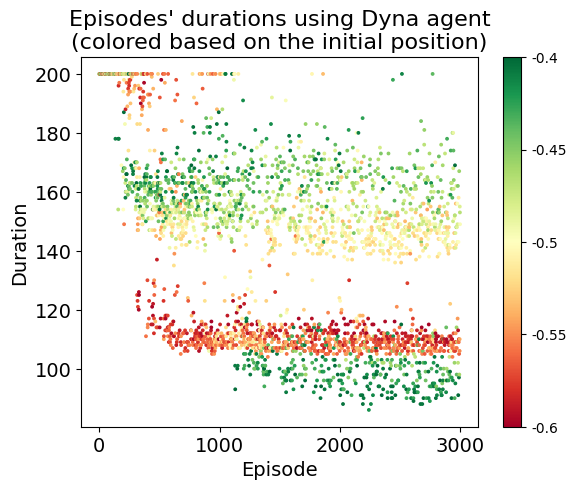

In [4]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

tt = (initial_xs+0.6)/0.2

scatter = plt.scatter(range(n_episodes), durations, s=3, c=tt, cmap='RdYlGn', rasterized=True)

plt.ylabel("Duration", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' durations using Dyna agent\n(colored based on the initial position)", fontsize=16)

norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=norm)
sm.set_array(tt)

cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels([-0.6, -0.55, -0.5, -0.45, -0.40])

plt.savefig("plots/E_Dyna_duration_colored.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: accumulated reward per episode**

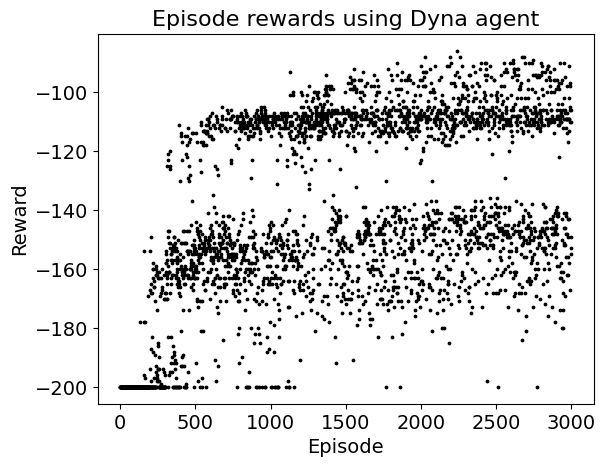

In [5]:
plt.scatter(range(n_episodes), rewards, s=3, c='black', label="Total reward", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episode rewards using Dyna agent", fontsize=16)
plt.savefig("plots/E_Dyna_reward.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: cumulative reward over episodes**

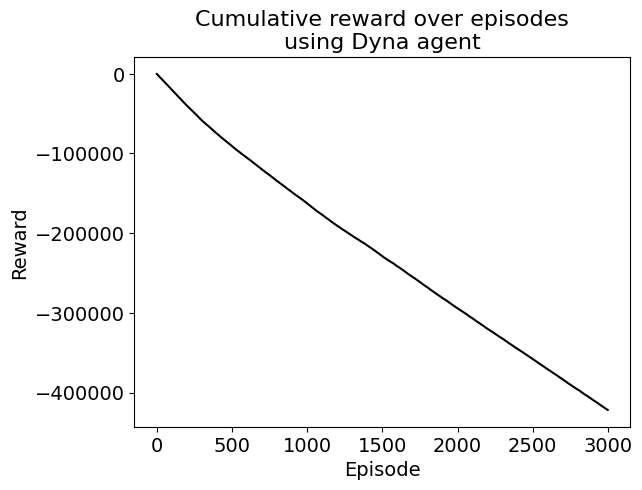

In [10]:
cum_rewards = rewards.cumsum()

plt.plot(range(n_episodes), cum_rewards, '-', c='black', rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Cumulative reward over episodes\nusing Dyna agent", fontsize=16)
plt.savefig("plots/E_Dyna_cumulativeReward.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Cumulative number of successes**

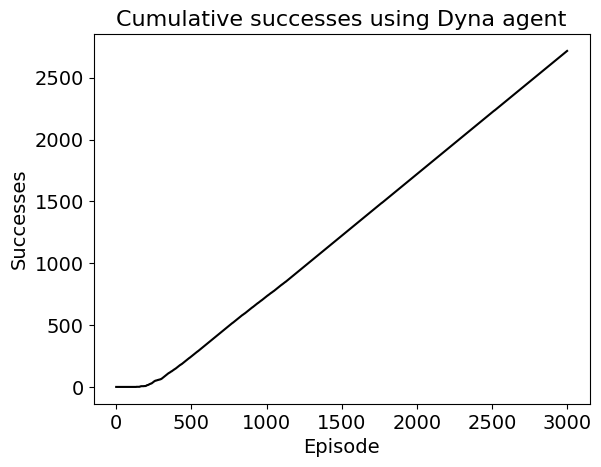

In [7]:
cum_successes = np.array([(1 if d < 200 else 0) for d in durations]).cumsum()

plt.plot(range(n_episodes), cum_successes, '-', c='black', rasterized=True)
plt.ylabel("Successes", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Cumulative successes using Dyna agent", fontsize=16)
plt.savefig("plots/E_Dyna_cumulativeSuccesses.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Training q-update**

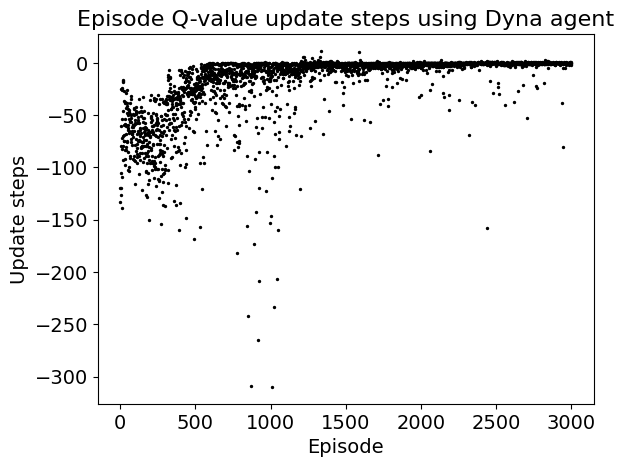

In [8]:
plt.scatter(range(n_episodes), q_updates, s = 2, c='black', rasterized=True)
plt.ylabel("Update steps", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episode Q-value update steps using Dyna agent", fontsize=16)
plt.savefig("plots/E_Dyna_update.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Training q-update step-by-step**

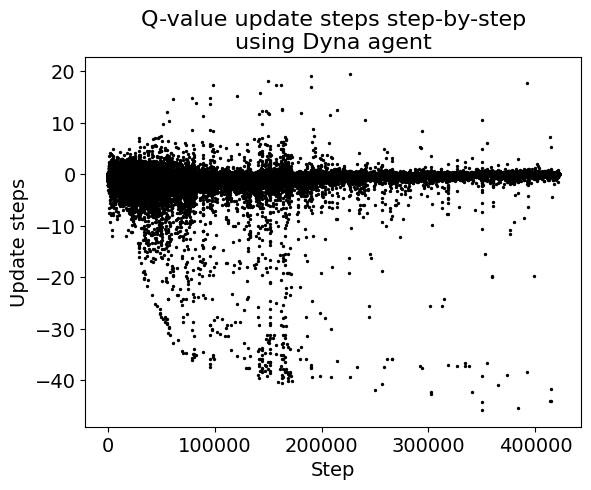

In [11]:
plt.scatter(range(q_updates_steps.size), q_updates_steps, s=2, c='black', rasterized=True)
plt.ylabel("Update steps", fontsize=14)
plt.xlabel("Step", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Q-value update steps step-by-step\nusing Dyna agent", fontsize=16)
plt.savefig("plots/E_Dyna_updateStep.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: max Q-values**

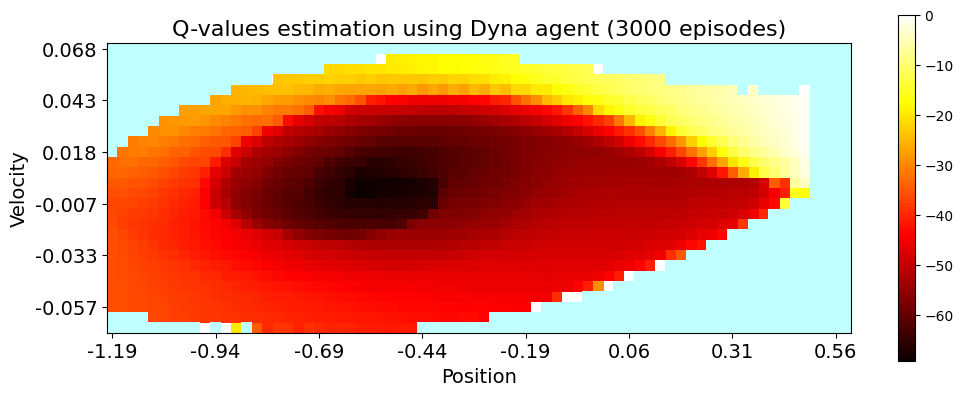

In [15]:
import matplotlib.patches as patches

state_space = np.array([[-1.2, -0.07], [0.6, 0.07]])
discr_step = np.array([0.025, 0.005])
num_states_vect = np.round(np.diff(state_space, axis=0).squeeze(axis=0) / discr_step).astype(int)

def index_to_x(i):
    return state_space[0,0] + i*discr_step[0] + discr_step[0]/2
def index_to_v(j):
    return state_space[0,1] + j*discr_step[1] + discr_step[1]/2

def plot_q_values_heatmap(q_values, visited, title = 'Q-values estimation using Dyna agent (3000 episodes)', print_colorbar = True, fontsz = 16):
    fig, ax = plt.subplots(figsize=(12, 4.5))
    
    q_values_flipped = np.flipud(q_values)
    visited_flipped = np.flipud(visited)
    
    cax = ax.imshow(q_values_flipped, cmap='hot', interpolation='nearest', vmin=np.min(max_Q_values), vmax=np.max(max_Q_values))
    if print_colorbar:
        fig.colorbar(cax)
    ax.set_title(title, fontsize=fontsz)
    ax.set_aspect('equal')
    ax.set_xlabel('Position', fontsize=14)
    ax.set_ylabel('Velocity', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    
    xticks = np.array([0,10,20,30,40,50,60,70], dtype=int)
    x_labels = index_to_x(xticks.astype(float))
    yticks = np.array([0,5,10,15,20,25], dtype=int)
    y_labels = -index_to_v(yticks.astype(float))
    
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'{label:.2f}' for label in x_labels])
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{label:.3f}' for label in y_labels])
    
    for (i, j), value in np.ndenumerate(visited_flipped):
        if not value:
            rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=0, edgecolor='none', facecolor='#bfffff', rasterized=True)
            ax.add_patch(rect)

plot_q_values_heatmap(max_Q_values, visited_states)
plt.savefig("plots/E_Dyna_Q_values_heatmap.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**Generate interesting trajectories**

In [9]:
# 0.4: 1487030054
# 0.44: 2140053466
# 0.48: 2041668854
# 0.52: 1474021400
# 0.56: 875215982
# 0.6: 994040270

# we select these seeds in order to get "interesting" initial states
interesting_seeds = [1487030054, 2140053466, 2041668854, 1474021400, 875215982, 994040270]

trajectories = np.full((len(interesting_seeds), 201), -1, dtype=int)
for i in range(len(interesting_seeds)):
    state, _ = env.reset(seed=interesting_seeds[i])
    done = False

    print("Initial state:", state[0])

    trajectories[i, 0] = agent.state_to_index(state)

    step = 1
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        state = next_state
        done = terminated or truncated

        trajectories[i, step] = agent.state_to_index(state)
        step += 1

Initial state: -0.40002355
Initial state: -0.4400238
Initial state: -0.48000452
Initial state: -0.52001286
Initial state: -0.56003314
Initial state: -0.5999885


**OPTIONAL: Save interesting trajectories**

In [12]:
# np.save("results/E_interesting_trajectories_Dyna", trajectories)

**OPTIONAL: Load interesting trajectories**

In [16]:
trajectories = np.load("results/E_interesting_trajectories_Dyna.npy")

**PLOT: interesting trajectories**

In [17]:
starting_positions = [-0.4, -0.44, -0.48, -0.52, -0.56, -0.6]

for i in range(trajectories.shape[0]):
    trajectory = trajectories[i][:np.where(trajectories[i] == -1)[0][0]]
    
    state_trajectory = np.column_stack((trajectory // num_states_vect[1], trajectory % num_states_vect[1]))
    
    plot_q_values_heatmap(max_Q_values, visited_states, f"Dyna trajectory with starting position ${starting_positions[i]}$", False, 20)
    
    plt.plot(state_trajectory[:, 0], 27-state_trajectory[:, 1], color='#00ff00', linewidth=5)

    plt.text(0.99, 0.01, f"Duration: {trajectory.size}", fontsize=18, color='black', ha='right', va='bottom', transform=plt.gca().transAxes)
    
    plt.savefig(f"plots/E_Dyna_trajectory_{6-i:02}.pdf", transparent=True, bbox_inches="tight", dpi=400)
    
    plt.close('all')

**PLOT: partial max Q-values**

NameError: name 'ax' is not defined

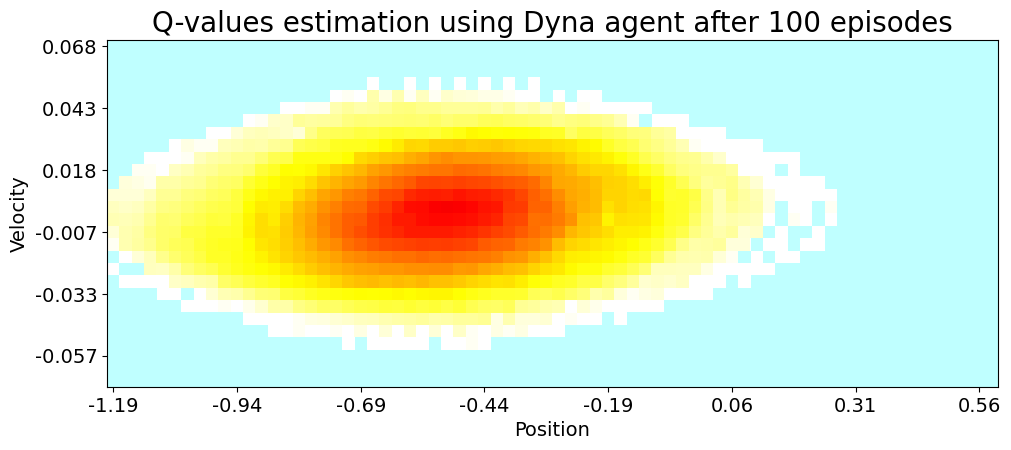

In [18]:
for i in range(partial_times.size):
    plot_q_values_heatmap(partial_max_Q_values[i], partial_visited_states[i], f'Q-values estimation using Dyna agent after {partial_times[i]} episodes', False, 20)
    
    plt.savefig(f"plots/E_Dyna_Q_values_heatmap_{partial_times[i]:04}_episodes.pdf", transparent=True, bbox_inches="tight", dpi=400)

    plt.text(1, 0, 'Bottom Right', fontsize=12, color='blue', ha='right', va='bottom', transform=ax.transAxes)
    
    plt.close('all')

## Agent testing

In [37]:
seed = 42

n_episodes = 1000

agent.eps = 0

episode_seeds = np.zeros(n_episodes, dtype=int)
initial_xs = np.zeros(n_episodes, dtype=float)
durations = np.zeros(n_episodes, dtype=int)
rewards = np.zeros(n_episodes, dtype=float)

rng_seed = np.random.default_rng(seed)
for episode in range(n_episodes):
    episode_seed = rng_seed.integers(2147483647).item()
    episode_seeds[episode] = episode_seed
    
    state, _ = env.reset(seed=episode_seed)
    done = False

    initial_xs[episode] = state[0].item()
    
    episode_reward = 0
    episode_steps = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        agent.observe(state, action, next_state, reward)
        # q_update = agent.update(state, action, next_state, reward)

        state = next_state
        done = terminated or truncated

        episode_reward += reward
        episode_steps += 1
    
    print(f"Episode: {episode}, Reward: {episode_reward: .4f}, Steps: {episode_steps}, epsilon: {agent.eps(agent.updates_counter): .4f}")

    durations[episode] = episode_steps
    rewards[episode] = episode_reward

Episode: 0, Reward: -93.0000, Steps: 93, epsilon:  0.0000
Episode: 1, Reward: -105.0000, Steps: 105, epsilon:  0.0000
Episode: 2, Reward: -108.0000, Steps: 108, epsilon:  0.0000
Episode: 3, Reward: -106.0000, Steps: 106, epsilon:  0.0000
Episode: 4, Reward: -147.0000, Steps: 147, epsilon:  0.0000
Episode: 5, Reward: -98.0000, Steps: 98, epsilon:  0.0000
Episode: 6, Reward: -98.0000, Steps: 98, epsilon:  0.0000
Episode: 7, Reward: -108.0000, Steps: 108, epsilon:  0.0000
Episode: 8, Reward: -97.0000, Steps: 97, epsilon:  0.0000
Episode: 9, Reward: -106.0000, Steps: 106, epsilon:  0.0000
Episode: 10, Reward: -110.0000, Steps: 110, epsilon:  0.0000
Episode: 11, Reward: -95.0000, Steps: 95, epsilon:  0.0000
Episode: 12, Reward: -105.0000, Steps: 105, epsilon:  0.0000
Episode: 13, Reward: -108.0000, Steps: 108, epsilon:  0.0000
Episode: 14, Reward: -104.0000, Steps: 104, epsilon:  0.0000
Episode: 15, Reward: -88.0000, Steps: 88, epsilon:  0.0000
Episode: 16, Reward: -90.0000, Steps: 90, epsi

**OPTIONAL: Save results**

In [38]:
data = {
    'seed': episode_seeds,
    'initial_x': initial_xs,
    'reward': rewards,
    'duration': durations
}

df = pd.DataFrame(data)

# df.to_csv('results/E_test_Dyna.csv', index=False)